In [1]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import transpile
from qiskit.tools.visualization import plot_histogram
from qiskit.circuit.library import QFT
import numpy as np
from qiskit_aer import AerSimulator

In [2]:
# Importamos el simulador. Con "method" le especificamos el método de simulación
simulador = AerSimulator(method = 'statevector')

In [3]:
def c_U_gate(phi0, phi1, power):
    U = QuantumCircuit(1)        
    for _ in range(power):
        U.rz(-phi0*4*np.pi, 0)
        U.p((phi1+phi0)*2*np.pi, 0)
    U = U.to_gate()
    U.name = "c_U(%f ,%f)^%i" % (np.round(phi0,5), np.round(phi1,5),power)
    U = U.control()
    return U

In [4]:
t_seed=3

a0 = 2.
delta0 = 0.2
theta0 = (a0+delta0)*2.**(-t_seed) 

a1 = 3.
delta1 = 0.
theta1 =(a1+ delta1)*2.**(-t_seed) 

print('theta0=', theta0, ' ->  2^t*theta0 = a0 + delta0 = ', 2**t_seed*theta0 , ' , a0 =' ,int(2**t_seed*theta0), '=>', format(int(2**t_seed*theta0),'b').zfill(t_seed) )
print('theta1=', theta1, ' ->  2^t*theta1 = a1 + delta1 = ', 2**t_seed*theta1 , ' , a1 =' ,int(2**t_seed*theta1), '=>', format(int(2**t_seed*theta1),'b').zfill(t_seed) )

theta0= 0.275  ->  2^t*theta0 = a0 + delta0 =  2.2  , a0 = 2 => 010
theta1= 0.375  ->  2^t*theta1 = a1 + delta1 =  3.0  , a1 = 3 => 011


/home/dcb/Programs/miniconda/miniconda3/envs/qiskit_qibo_penny_2/lib/python3.11/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


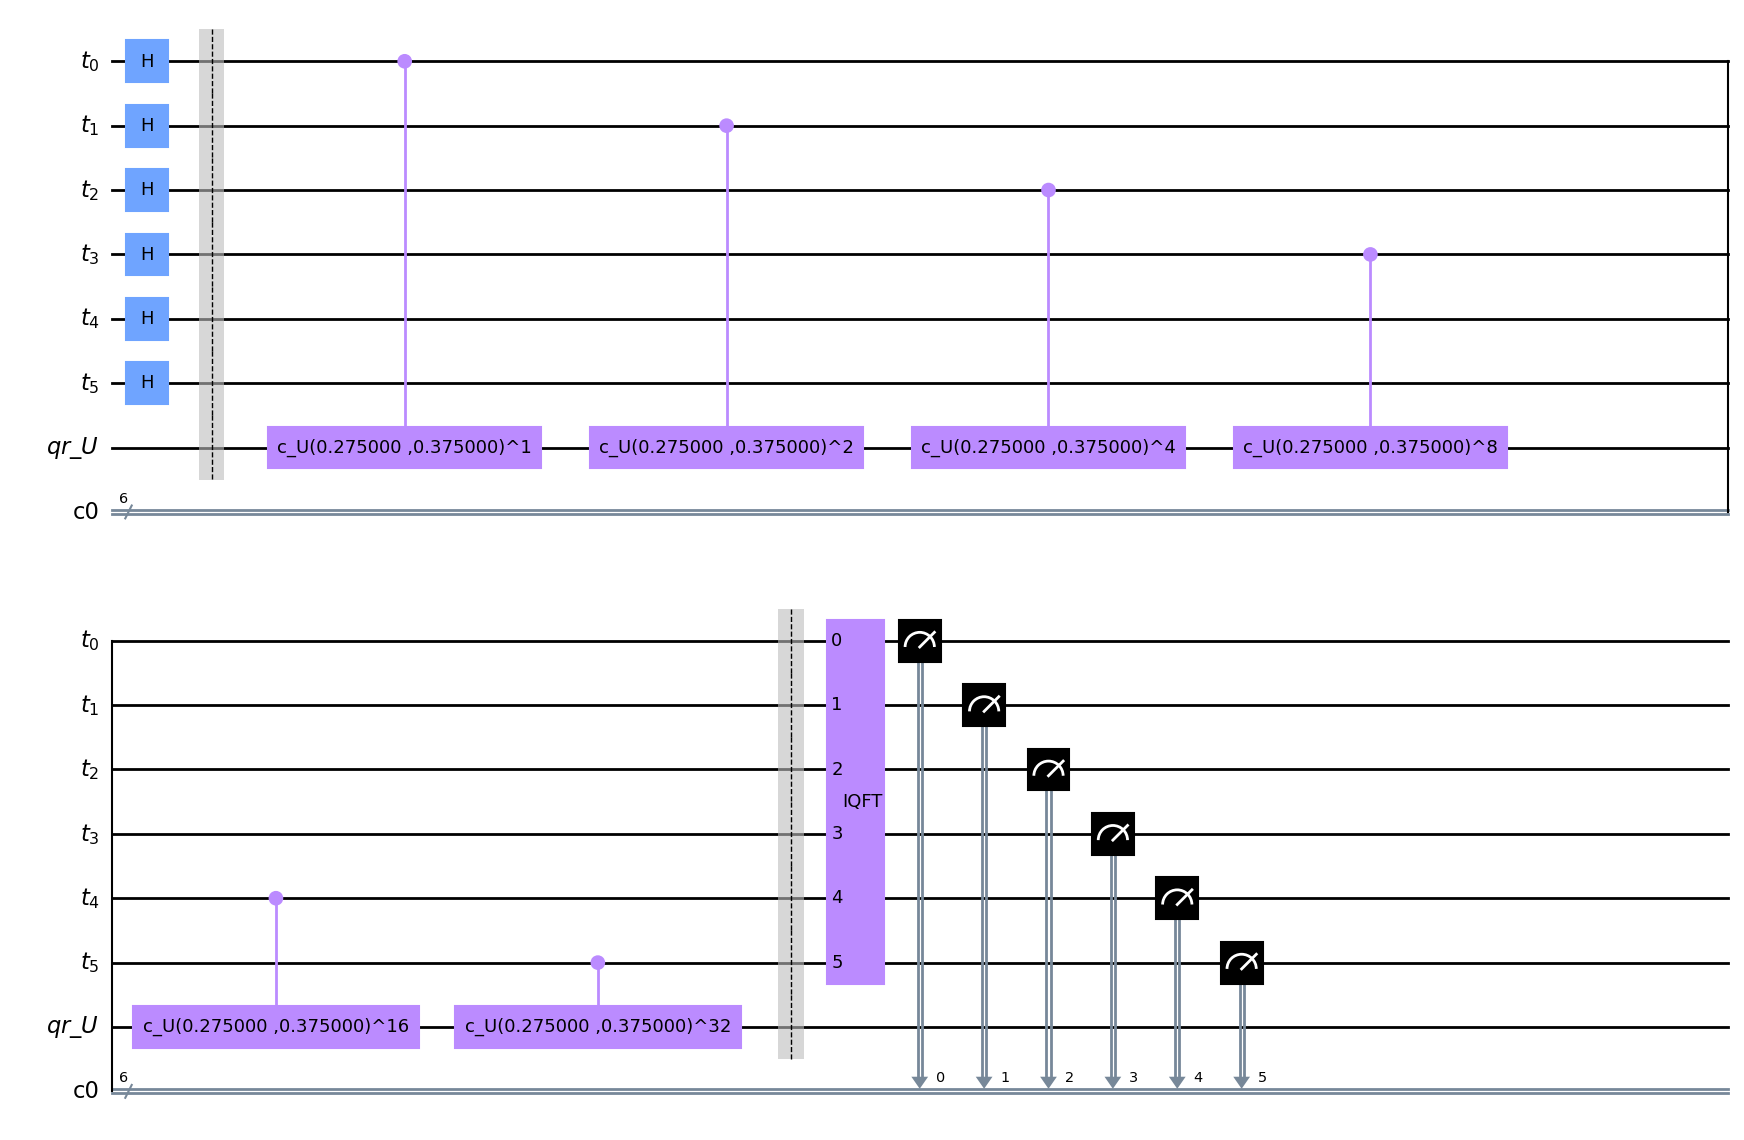

In [5]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

t = 6 # la dimensión del registro de evaluación 
n = 1 # la dimensiónd el espacio de representación del opeador U

qr_t = QuantumRegister(t,name="t")
qr_n = QuantumRegister(n,name="qr_U") # aquí 1 es la dimensión del espacio en el que opera U
cr_t = ClassicalRegister(t)

circuit_QPE = QuantumCircuit(qr_t, qr_n, cr_t)   

##########################################################################
#inicializamos la ancilla en un autoestado |u> =|0> o |u> = |1>
#circuit_QPE.x(qra)   
##########################################################################

circuit_QPE.h(range(t))
circuit_QPE.barrier()

# aplicamos los operadores controlados c-U^j 
for j in range(t):
    circuit_QPE.append(c_U_gate(theta0, theta1, 2**j), [qr_t[j]]+qr_n[:])
    

circuit_QPE.barrier()

# aplicamos la QFT^-1 que está definida en macro.py 
QFT_gate = QFT(t, inverse=True).to_gate() 
circuit_QPE.append(QFT_gate, qr_t)


circuit_QPE.measure(qr_t,cr_t)

circuit_QPE.draw(output="mpl")

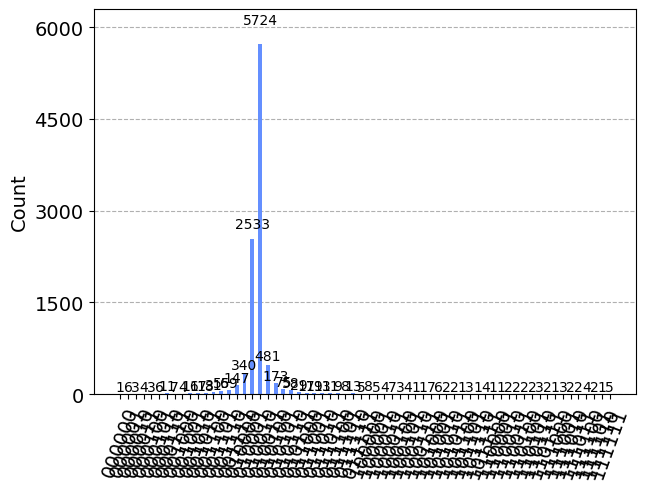

In [6]:
# transpilamos
t_circuit_QPE = transpile(circuit_QPE, backend = simulador)

# Ejecutamos la simulación con 1000 shots 
result = simulador.run(t_circuit_QPE, shots = 10000).result()
counts = result.get_counts()
plot_histogram(counts)

In [7]:
max(counts, key=counts.get)

'010010'

In [8]:
a_resultante = int(max(counts, key=counts.get),2)

# Seleccionamos el autovalor asociado a |u> 
theta = theta0  # si |0>
#theta = tetha1   # si |1>

print('el valor de phi original era =', theta)

print('la mejor aproximación al valor verdadero es a/2^t =', a_resultante*2**(-t))

print('el error relativo es delta/(2^t phi) =', (theta -a_resultante*2**(-t))/theta)

el valor de phi original era = 0.275
la mejor aproximación al valor verdadero es a/2^t = 0.28125
el error relativo es delta/(2^t phi) = -0.022727272727272645


In [9]:
t_seed = 3

a0 = 1.
delta0 = 0.1
phi0 = (a0+ delta0)*2.**(-t_seed) 

a1 = 3.
delta1 = 0.1
phi1 =(a1+ delta1)*2.**(-t_seed) 

print('phi0=', phi0, ' ->   2^t*phi0 = a0 + delta0 = ', 2**t_seed*phi0 , ' , a0 =' ,int(2**t_seed*phi0), '=>', format(int(2**t_seed*phi0),'b').zfill(t_seed) )
print('phi1=', phi1, ' ->   2^t*phi1 = a1 + delta1 = ', 2**t_seed*phi1 , ' , a1 =' ,int(2**t_seed*phi0), '=>', format(int(2**t_seed*phi1),'b').zfill(t_seed) )


phi0= 0.1375  ->   2^t*phi0 = a0 + delta0 =  1.1  , a0 = 1 => 001
phi1= 0.3875  ->   2^t*phi1 = a1 + delta1 =  3.1  , a1 = 1 => 011


/home/dcb/Programs/miniconda/miniconda3/envs/qiskit_qibo_penny_2/lib/python3.11/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


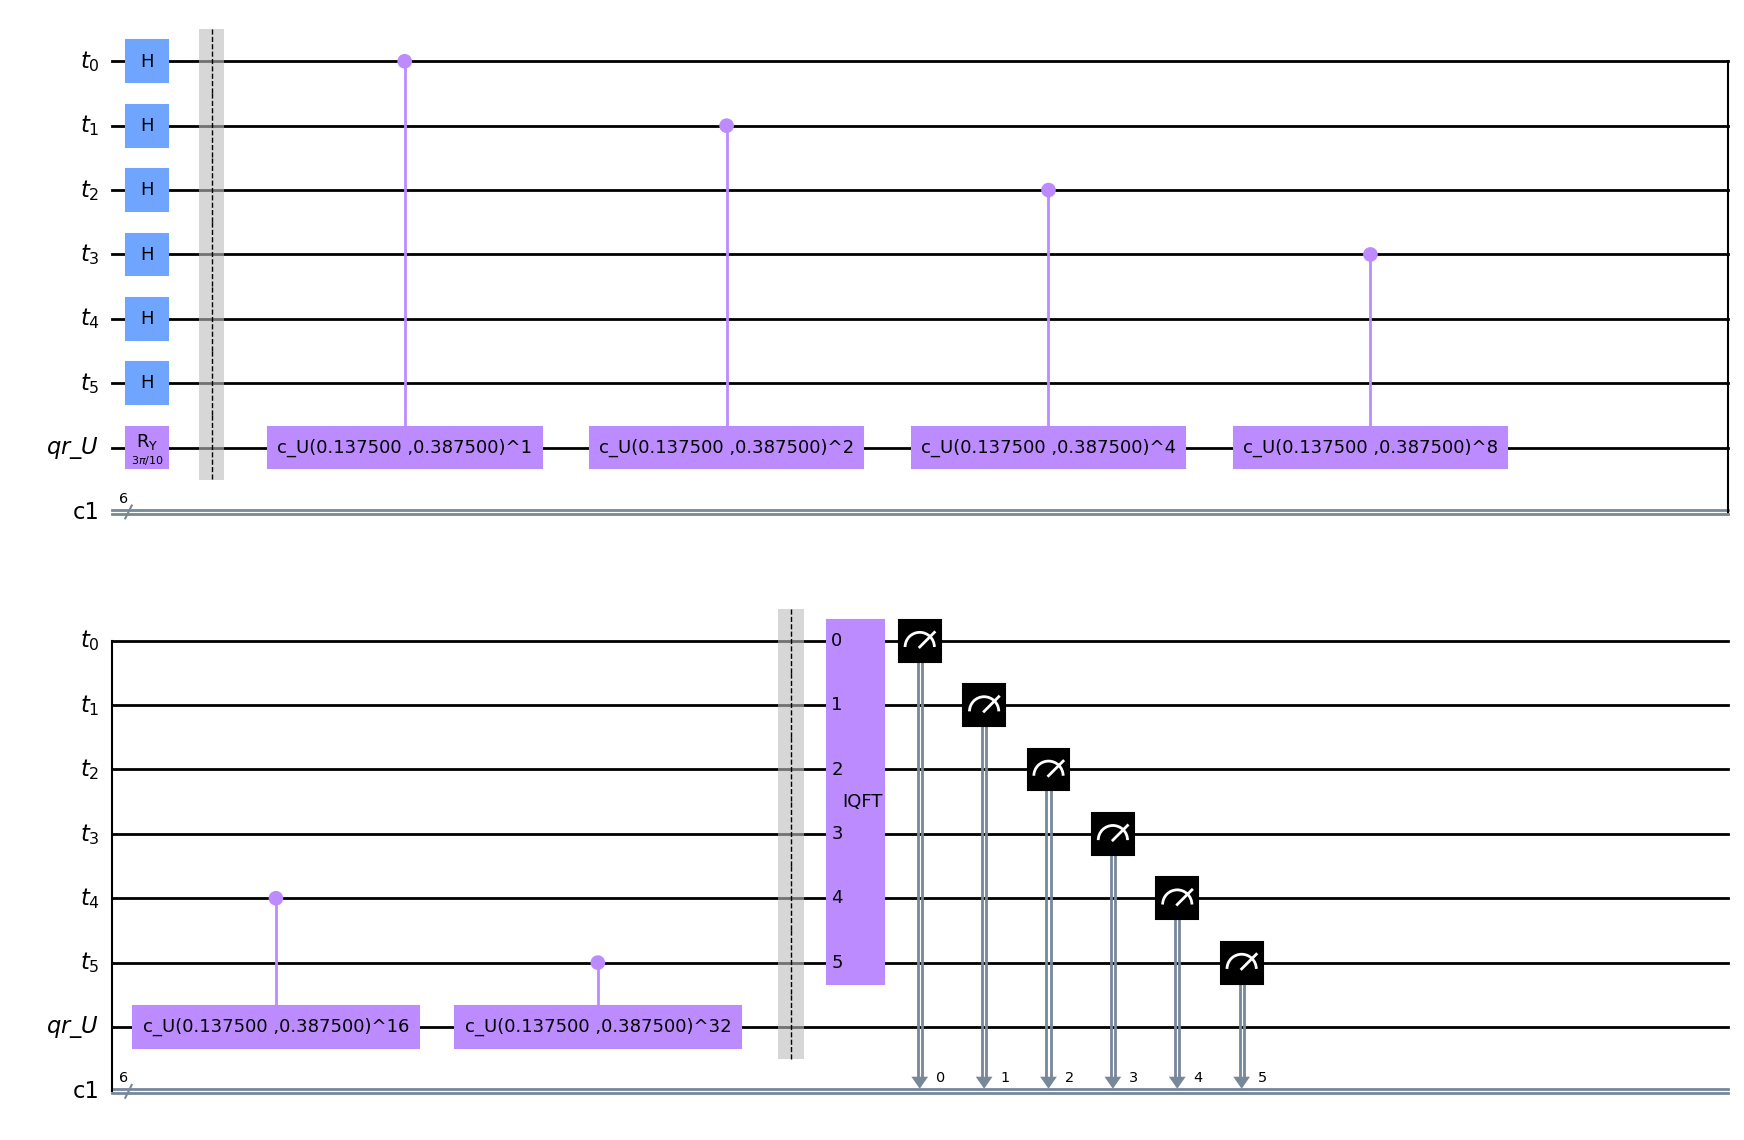

In [10]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

t = 6 # la dimensión del registro de evaluación 
n = 1 # la dimensiónd el espacio de representación del opeador U

qr_t=QuantumRegister(t, name="t")
qr_n=QuantumRegister(n, name="qr_U") # aquí 1 es la dimensión del espacio en el que opera U
cr_t=ClassicalRegister(t)

circuit_QPE_2 = QuantumCircuit(qr_t, qr_n, cr_t)   

##########################################################################
#inicializamos la ancilla en una combinación cos(th/2)|0> + sin(th/2)|1>
theta = 2*np.pi*0.15 
circuit_QPE_2.ry(theta, qr_n) 
##########################################################################

circuit_QPE_2.h(range(t))
circuit_QPE_2.barrier()

# aplicamos los operadores controlados c-U^j 
for j in range(t):
    circuit_QPE_2.append(c_U_gate(phi0, phi1, 2**j),[qr_t[j]]+qr_n[:])
#    circuit_QPE_2.cp(2*np.pi*phi1*(2**j), qr_t[j], qr_a); # This is C-U
    

circuit_QPE_2.barrier()

# aplicamos la QFT^-1 que está definida en macro.py 
QFT_gate = QFT(t, inverse=True).to_gate() 
circuit_QPE_2.append(QFT_gate, qr_t)

circuit_QPE_2.measure(qr_t,cr_t)

circuit_QPE_2.draw(output="mpl")

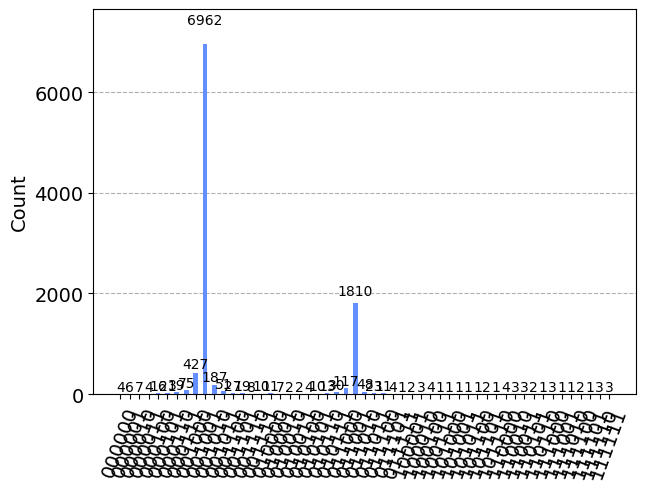

In [11]:
# transpilamos
t_circuit_QPE_2 = transpile(circuit_QPE_2, backend = simulador)

# Ejecutamos la simulación con 1000 shots 
result_2 = simulador.run(t_circuit_QPE_2, shots = 10000).result()
counts_2 = result_2.get_counts()
plot_histogram(counts_2)

/home/dcb/Programs/miniconda/miniconda3/envs/qiskit_qibo_penny_2/lib/python3.11/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


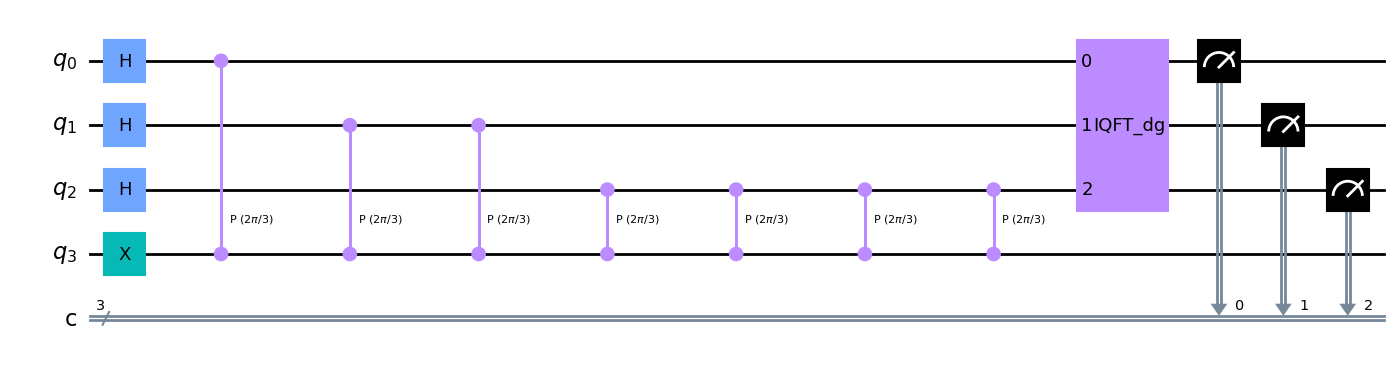

In [12]:
# Create and set up circuit
t = 3 # la dimensión del registro de evaluación 
n = 1 # la dimensiónd el espacio de representación del opeador U
circuit_QPE_P = QuantumCircuit(t+n, t)

# Apply H-Gates to counting qubits:
for qubit in range(t):
    circuit_QPE_P.h(qubit)

# Prepare our eigenstate |psi>:
circuit_QPE_P.x(t)

# Do the controlled-U operations:
angle = 2*np.pi/3
repetitions = 1
for counting_qubit in range(t):
    for i in range(repetitions):
        circuit_QPE_P.cp(angle, counting_qubit, t);
    repetitions *= 2

# Do the inverse QFT:
circuit_QPE_P = circuit_QPE_P.compose(QFT(t, inverse=True), [i for i in range(t)])

# Measure of course!
for i in range(t):
    circuit_QPE_P.measure(i,i)

circuit_QPE_P.draw(output = 'mpl')

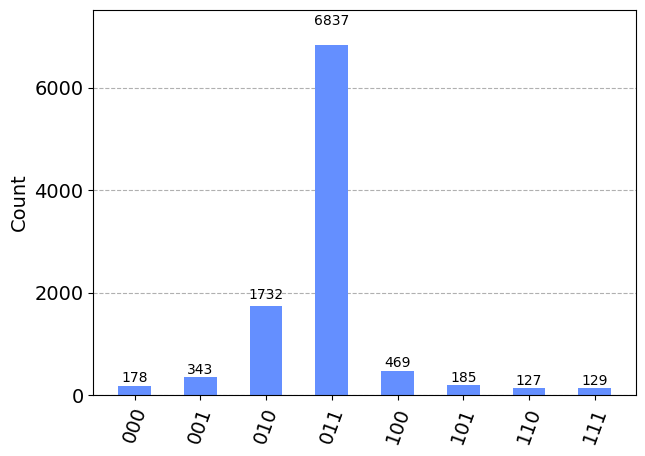

In [13]:
# transpilamos
t_circuit_QPE_P = transpile(circuit_QPE_P, backend = simulador)

# Ejecutamos la simulación con 1000 shots 
result_p = simulador.run(t_circuit_QPE_P, shots = 10000).result()
counts_p = result_p.get_counts()
plot_histogram(counts_p)

/home/dcb/Programs/miniconda/miniconda3/envs/qiskit_qibo_penny_2/lib/python3.11/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


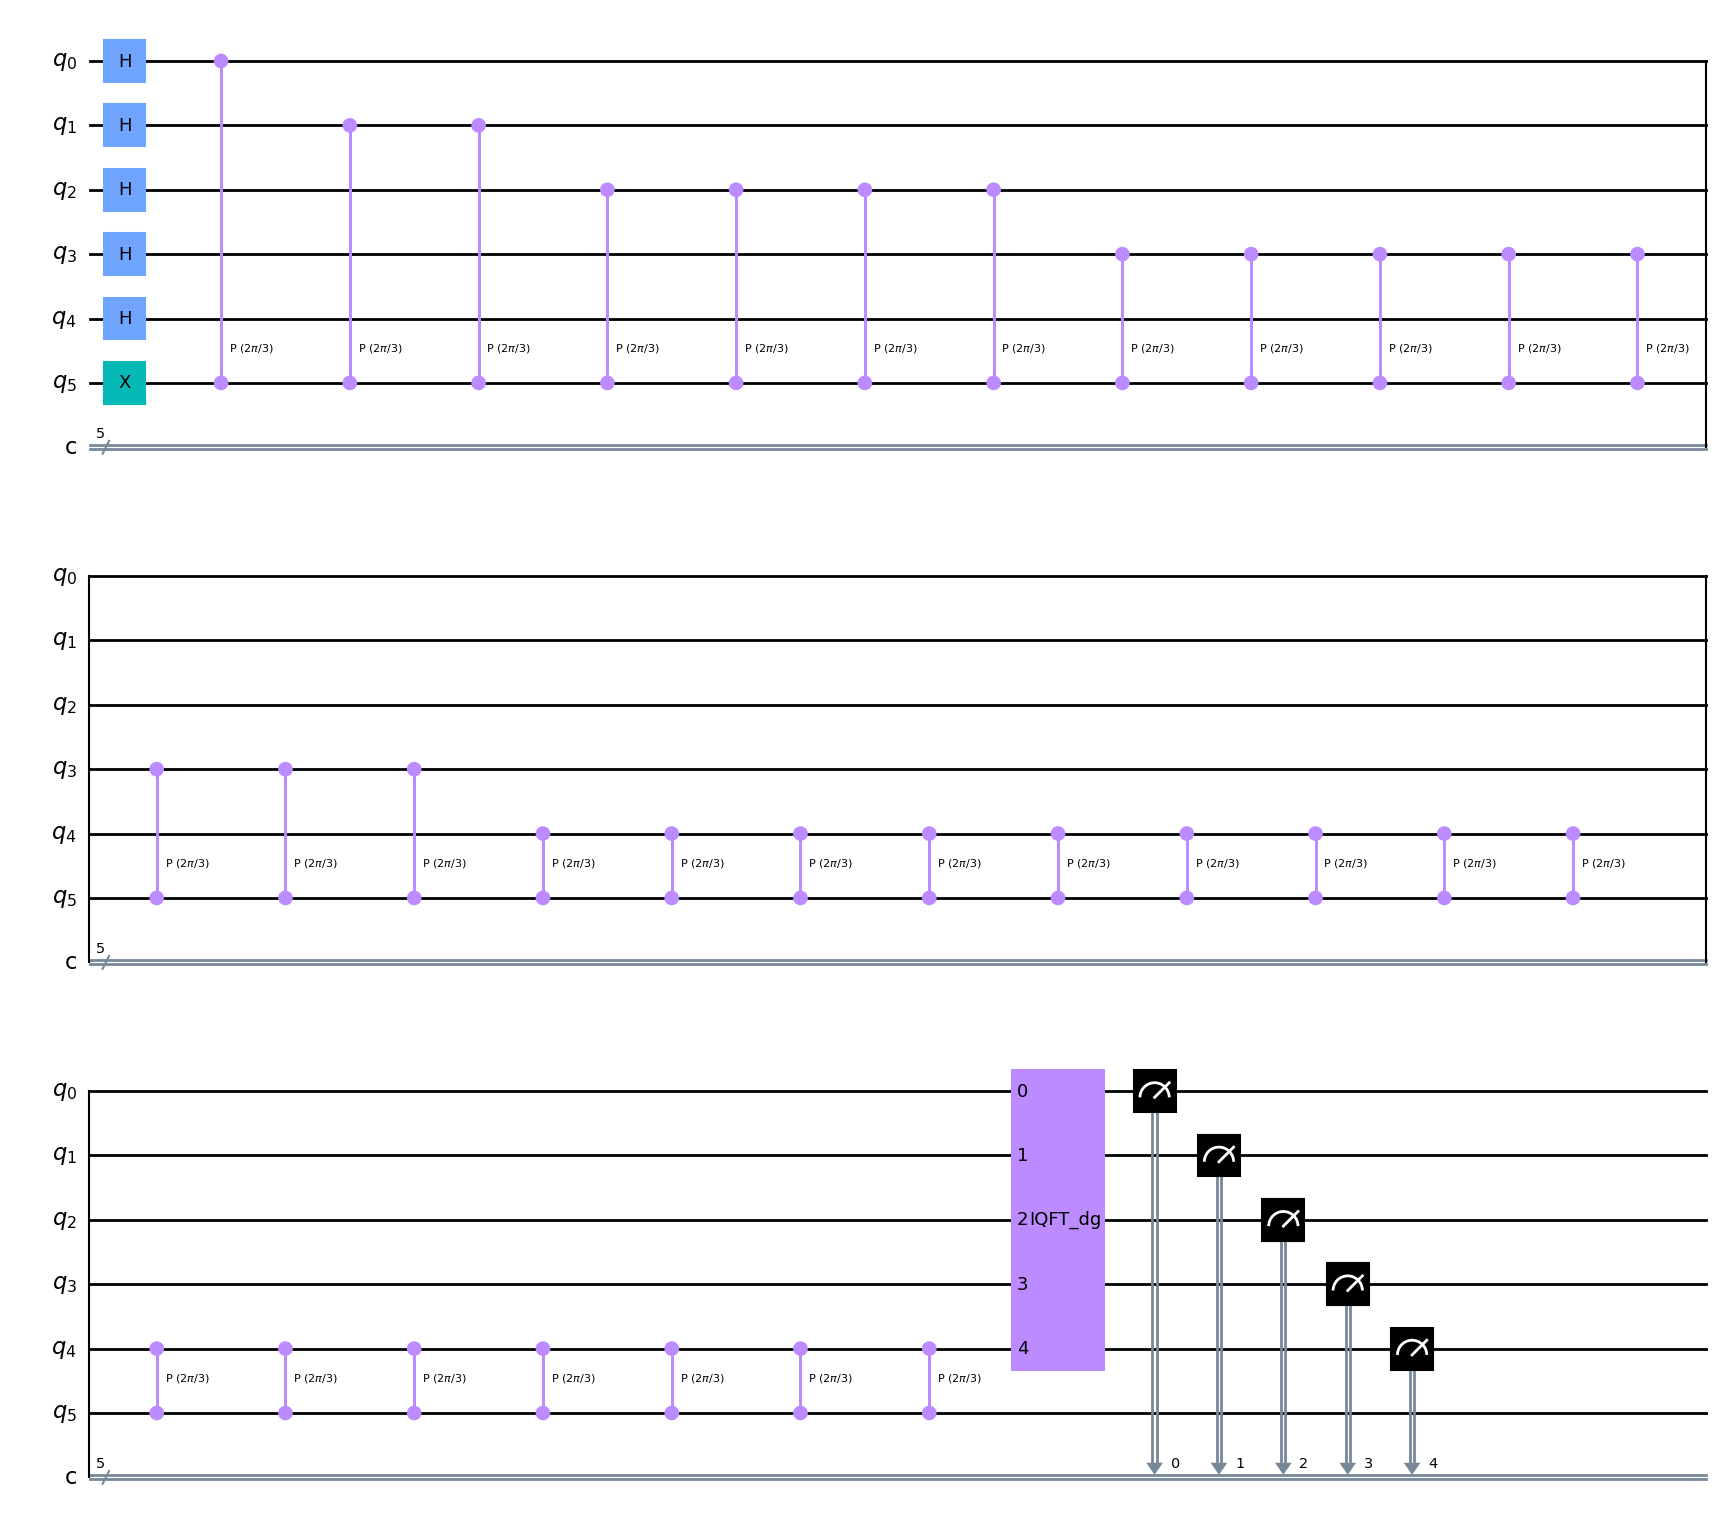

In [14]:
t = 5 # la dimensión del registro de evaluación 
n = 1 # la dimensiónd el espacio de representación del opeador U
circuit_QPE_P = QuantumCircuit(t+n, t)

# Apply H-Gates to counting qubits:
for qubit in range(t):
    circuit_QPE_P.h(qubit)

# Prepare our eigenstate |psi>:
circuit_QPE_P.x(t)

# Do the controlled-U operations:
angle = 2*np.pi/3
repetitions = 1
for counting_qubit in range(t):
    for i in range(repetitions):
        circuit_QPE_P.cp(angle, counting_qubit, t);
    repetitions *= 2

# Do the inverse QFT:
circuit_QPE_P = circuit_QPE_P.compose(QFT(t, inverse=True), [i for i in range(t)])

# Measure of course!
for i in range(t):
    circuit_QPE_P.measure(i,i)

circuit_QPE_P.draw(output = 'mpl')

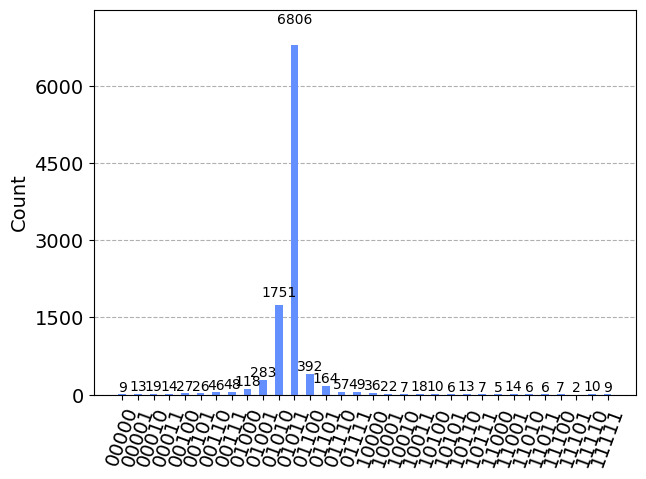

In [15]:
# transpilamos
t_circuit_QPE_P = transpile(circuit_QPE_P, backend = simulador)

# Ejecutamos la simulación con 1000 shots 
result_p = simulador.run(t_circuit_QPE_P, shots = 10000).result()
counts_p = result_p.get_counts()
plot_histogram(counts_p)